# Visualisation D'une Sortie Voile

In [ ]:
# importer les bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import folium
from math import radians, cos, sin, sqrt, atan2

### Choisir l'activité à visualiser

In [ ]:
# Charger le CSV (choisir entre les deux)
CSV_FILES = {
    "Activite 1": "/gpx_output/activity_20110577449.csv", # Birdy = Bateau sur foil
    "Activite 2": "/gpx_output/activity_16613729286.csv"  # Catamaran
}

# Choix de l'activite:
CHOICE = "Activite 1"
##CHOICE = "Activite 2"

In [ ]:
# Chargement du fichier + calculs
df = pd.read_csv(CSV_FILES[CHOICE])
df.head()

# Conversion du temps
df["time"] = pd.to_datetime(df["time"])
df = df.dropna(subset=["lat", "lon", "time"])

df.head()

def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # Terre en mètres
    phi1, phi2 = radians(lat1), radians(lat2)
    dphi = radians(lat2 - lat1)
    dlambda = radians(lon2 - lon1)

    a = sin(dphi/2)**2 + cos(phi1)*cos(phi2)*sin(dlambda/2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1 - a))

# Calcul distance et vitesse
distances = [0]
speeds = [0]

for i in range(1, len(df)):
    d = haversine(df.lat[i-1], df.lon[i-1], df.lat[i], df.lon[i])
    t = (df.time[i] - df.time[i-1]).total_seconds()
    distances.append(d)
    speeds.append(d / t if t > 0 else 0)

df["distance_m"] = distances
df["speed_mps"] = speeds
df["speed_knots"] = df["speed_mps"] * 1.94384

### 1. Trace GPS

In [ ]:
m = folium.Map(
    location=[df.lat.mean(), df.lon.mean()],
    zoom_start=13,
    tiles="OpenStreetMap"
)

coords = list(zip(df.lat, df.lon))
folium.PolyLine(coords, color="blue", weight=3).add_to(m)

m


### 2. Variation de la vitesse

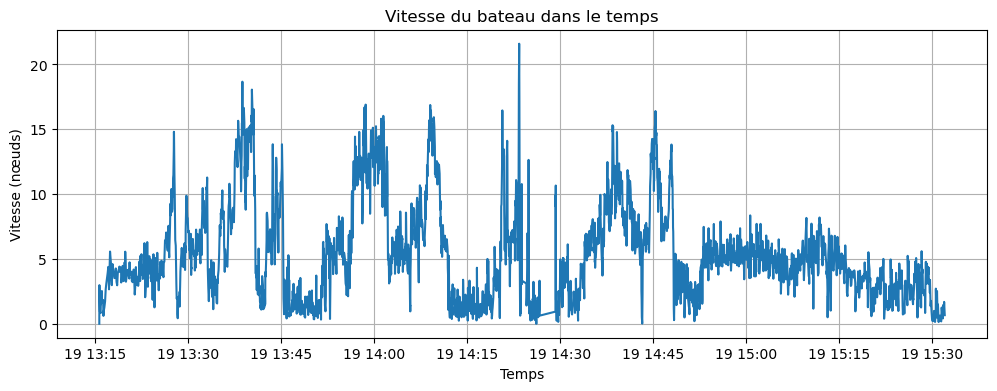

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(df.time, df.speed_knots)
plt.ylabel("Vitesse (nœuds)")
plt.xlabel("Temps")
plt.title("Vitesse du bateau dans le temps")
plt.grid()
plt.show()


### 3. Trace GPS avec variation de la vitese

In [ ]:
m_speed = folium.Map(
    location=[df.lat.mean(), df.lon.mean()],
    zoom_start=13,
    tiles="OpenStreetMap"
)

max_speed = df.speed_knots.max()

for i in range(1, len(df)):
    speed_norm = df.speed_knots[i] / max_speed
    color = mcolors.to_hex(plt.cm.viridis(speed_norm))

    folium.PolyLine(
        [(df.lat[i-1], df.lon[i-1]), (df.lat[i], df.lon[i])],
        color=color,
        weight=4,
        opacity=0.9
    ).add_to(m_speed)

m_speed



### 4. Détection des Mnoeuvres

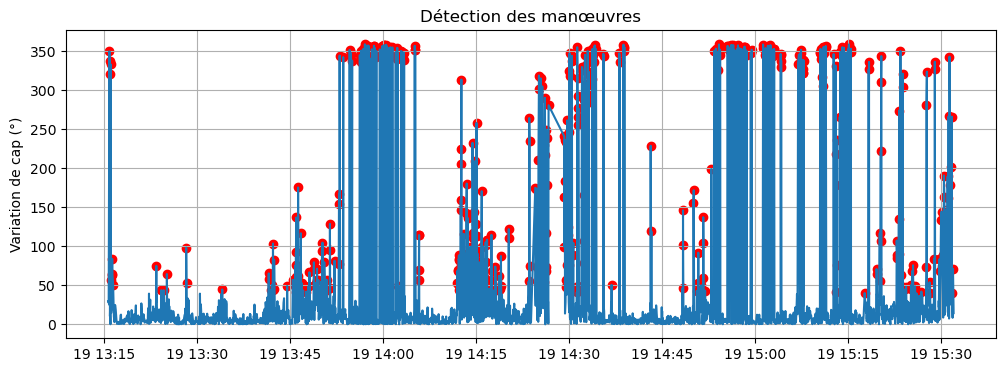

In [ ]:
# Calcul du cap (bearing)
def bearing(lat1, lon1, lat2, lon2):
    y = sin(radians(lon2-lon1)) * cos(radians(lat2))
    x = cos(radians(lat1))*sin(radians(lat2)) - sin(radians(lat1))*cos(radians(lat2))*cos(radians(lon2-lon1))
    return (atan2(y, x) * 180 / np.pi + 360) % 360

bearings = [0]
for i in range(1, len(df)):
    bearings.append(bearing(df.lat[i-1], df.lon[i-1], df.lat[i], df.lon[i]))

df["bearing"] = bearings
df["bearing_change"] = df["bearing"].diff().abs()

# Manœuvres = changement de cap important
maneuvers = df[df["bearing_change"] > 40]

plt.figure(figsize=(12,4))
plt.plot(df.time, df.bearing_change)
plt.scatter(maneuvers.time, maneuvers.bearing_change, color="red")
plt.ylabel("Variation de cap (°)")
plt.title("Détection des manœuvres")
plt.grid()
plt.show()


### 5. Détection des manoeuvres sur une carte

In [ ]:
m_turns = folium.Map(
    location=[df.lat.mean(), df.lon.mean()],
    zoom_start=13
)

for _, row in maneuvers.iterrows():
    folium.CircleMarker(
        location=[row.lat, row.lon],
        radius=5,
        color="red",
        fill=True
    ).add_to(m_turns)

folium.PolyLine(coords, color="blue", weight=2).add_to(m_turns)

m_turns
